In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Any
import time
import os

In [41]:
class KroneckerLaplace:
    """
    A scalable Laplace approximation for neural networks based on Kronecker-factored curvature.
    Fixed implementation with proper scaling and numerical stability.
    """
    
    def __init__(self, model: nn.Module, likelihood: str = 'classification'):
        self.model = model
        self.likelihood = likelihood
        self.device = next(model.parameters()).device
        
        # Storage for Kronecker factors
        self.kronecker_factors = {}
        self.prior_precision = 1.0
        self.dataset_size = 1
        
        # Hook handles
        self.hook_handles = []
        
    def compute_posterior(self, 
                         train_loader: DataLoader,
                         prior_precision: float = 1.0,
                         num_samples: int = 1000) -> None:
        """
        Compute the Kronecker-factored Laplace approximation.
        """
        self.prior_precision = prior_precision
        self.dataset_size = len(train_loader.dataset)
        
        print("Registering hooks...")
        self._register_hooks()
        
        print("Estimating Kronecker factors...")
        self._estimate_kronecker_factors(train_loader, num_samples)
        
        print("Removing hooks...")
        self._remove_hooks()
        
        print("Posterior computation completed!")
        
    def _register_hooks(self) -> None:
        """Register forward and backward hooks to capture activations and gradients."""
        self.activations = {}
        self.gradients = {}
        
        def make_forward_hook(layer_name):
            def forward_hook(module, input, output):
                if isinstance(input, tuple):
                    input = input[0]
                # Store input activations
                self.activations[layer_name] = input.detach().clone()
            return forward_hook
        
        def make_backward_hook(layer_name):
            def backward_hook(module, grad_input, grad_output):
                if isinstance(grad_output, tuple):
                    grad_output = grad_output[0]
                # Store gradients w.r.t. pre-activations
                self.gradients[layer_name] = grad_output.detach().clone()
            return backward_hook
        
        # Register hooks for linear layers
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                forward_handle = module.register_forward_hook(make_forward_hook(name))
                backward_handle = module.register_backward_hook(make_backward_hook(name))
                self.hook_handles.extend([forward_handle, backward_handle])
                print(f"Registered hooks for layer: {name}")
    
    def _remove_hooks(self) -> None:
        """Remove all registered hooks."""
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles.clear()
    
    def _estimate_kronecker_factors(self, train_loader: DataLoader, num_samples: int) -> None:
        """
        Estimate Kronecker factors with proper scaling and numerical stability.
        """
        original_mode = self.model.training
        self.model.train()
        
        accumulators = {}
        sample_count = 0
        
        print(f"Processing up to {num_samples} samples...")
        
        for batch_idx, (data, target) in enumerate(train_loader):
            if sample_count >= num_samples:
                break
                
            data, target = data.to(self.device), target.to(self.device)
            
            # Forward pass
            output = self.model(data)
            
            # Compute loss
            if self.likelihood == 'classification':
                loss = F.cross_entropy(output, target)
            else:
                loss = F.mse_loss(output, target)
            
            # Backward pass
            self.model.zero_grad()
            loss.backward()
            
            # Process each layer
            with torch.no_grad():
                for name, module in self.model.named_modules():
                    if isinstance(module, nn.Linear) and name in self.activations:
                        a = self.activations[name]  # input activations
                        g = self.gradients[name]    # gradients
                        
                        # Flatten if needed
                        if a.dim() > 2:
                            a = a.flatten(1)
                        if g.dim() > 2:
                            g = g.flatten(1)
                        
                        if name not in accumulators:
                            in_dim = a.shape[1]
                            out_dim = g.shape[1]
                            
                            accumulators[name] = {
                                'Q_sum': torch.zeros(in_dim, in_dim, device=self.device),
                                'H_sum': torch.zeros(out_dim, out_dim, device=self.device),
                                'count': 0,
                                'in_dim': in_dim,
                                'out_dim': out_dim
                            }
                        
                        # Compute batch statistics
                        batch_Q = torch.einsum('bi,bj->ij', a, a) / a.shape[0]
                        batch_H = torch.einsum('bi,bj->ij', g, g) / g.shape[0]
                        
                        accumulators[name]['Q_sum'] += batch_Q
                        accumulators[name]['H_sum'] += batch_H
                        accumulators[name]['count'] += 1
                
                sample_count += data.shape[0]
                if sample_count % 1000 == 0:
                    print(f"Processed {sample_count} samples...")
        
        # Restore original mode
        self.model.train(original_mode)
        
        # Compute final factors with proper regularization
        print("Computing final Kronecker factors...")
        with torch.no_grad():
            for name, acc in accumulators.items():
                if acc['count'] == 0:
                    continue
                    
                Q = acc['Q_sum'] / acc['count']
                H = acc['H_sum'] / acc['count']
                
                print(f"Layer {name}: Q shape {Q.shape}, H shape {H.shape}")
                
                # Add regularization - much more conservative
                # Use smaller regularization to avoid over-constraining
                reg_strength = 1e-3
                Q_reg = Q + reg_strength * torch.eye(Q.shape[0], device=self.device)
                H_reg = H + reg_strength * torch.eye(H.shape[0], device=self.device)
                
                # Store covariance matrices (not precision matrices)
                # This is crucial - we want to sample from N(0, covariance)
                self.kronecker_factors[name] = {
                    'Q_cov': Q_reg,  # Covariance for inputs
                    'H_cov': H_reg,  # Covariance for outputs  
                    'in_dim': acc['in_dim'],
                    'out_dim': acc['out_dim']
                }
                
                # Print some diagnostics
                Q_norm = torch.norm(Q_reg).item()
                H_norm = torch.norm(H_reg).item()
                print(f"  Q norm: {Q_norm:.6f}, H norm: {H_norm:.6f}")
    
    def sample_weights(self, num_samples: int = 1, temperature: float = 0.01) -> List[Dict[str, torch.Tensor]]:
        """
        Sample weights with proper temperature scaling.
        
        temperature: controls how much we perturb the weights (0 = no perturbation, 1 = full perturbation)
        """
        if not self.kronecker_factors:
            raise ValueError("Must compute posterior before sampling")
        
        samples = []
        
        for _ in range(num_samples):
            sample_state_dict = {}
            
            for name, module in self.model.named_modules():
                if isinstance(module, nn.Linear) and name in self.kronecker_factors:
                    factors = self.kronecker_factors[name]
                    
                    # Get original weights
                    W_original = module.weight.data  # shape: (out_dim, in_dim)
                    
                    # Get covariance matrices
                    Q_cov = factors['Q_cov']  # shape: (in_dim, in_dim)
                    H_cov = factors['H_cov']  # shape: (out_dim, out_dim)
                    
                    # Compute matrix square roots for sampling
                    Q_sqrt = self._matrix_sqrt(Q_cov)  # shape: (in_dim, in_dim)
                    H_sqrt = self._matrix_sqrt(H_cov)  # shape: (out_dim, out_dim)
                    
                    # Sample noise matrix
                    Z = torch.randn(factors['out_dim'], factors['in_dim'], device=self.device)
                    
                    # Compute perturbation: W_perturbed = H_sqrt @ Z @ Q_sqrt.T
                    # This gives the correct covariance structure
                    perturbation = H_sqrt @ Z @ Q_sqrt.T
                    
                    # Apply temperature scaling - VERY conservative
                    scaled_perturbation = temperature * perturbation
                    
                    # Ensure perturbation is reasonable
                    perturbation_norm = torch.norm(scaled_perturbation).item()
                    weight_norm = torch.norm(W_original).item()
                    relative_change = perturbation_norm / (weight_norm + 1e-8)
                    
                    # if relative_change > 0.1:  # Cap at 10% relative change
                    #     scale_factor = 0.1 / relative_change
                    #     scaled_perturbation = scale_factor * scaled_perturbation
                    #     print(f"Warning: Capping perturbation for layer {name}, relative change: {relative_change:.4f}")
                    
                    W_sample = W_original + scaled_perturbation
                    
                    sample_state_dict[name + '.weight'] = W_sample
                    
                    # Handle bias with even more conservative scaling
                    if hasattr(module, 'bias') and module.bias is not None:
                        bias_original = module.bias.data
                        # Use diagonal of H_cov for bias uncertainty
                        bias_std = torch.sqrt(torch.diag(H_cov)).mean()
                        bias_perturbation = temperature * 0.1 * bias_std * torch.randn_like(bias_original)
                        sample_state_dict[name + '.bias'] = bias_original + bias_perturbation
            
            samples.append(sample_state_dict)
        
        return samples
    
    def _matrix_sqrt(self, A: torch.Tensor) -> torch.Tensor:
        """Compute matrix square root using eigen decomposition."""
        try:
            # Eigen decomposition for symmetric matrices
            L, V = torch.linalg.eigh(A)
            # Ensure positive eigenvalues
            L = torch.clamp(L, min=1e-8)
            return V @ torch.diag(torch.sqrt(L)) @ V.T
        except:
            # Fallback: use identity
            print("Warning: Matrix sqrt failed, using identity")
            return torch.eye(A.shape[0], device=A.device)
    
    def predictive_distribution(self, 
                              x: torch.Tensor, 
                              num_samples: int = 50,
                              temperature: float = 0.001,
                              return_samples: bool = False):
        """
        Compute predictive distribution without modifying original model weights.
        """
        # Store original state and create a deep copy to avoid any in-place changes
        original_state_dict = {k: v.clone() for k, v in self.model.state_dict().items()}
        
        predictions = []
        
        # Sample weights
        weight_samples = self.sample_weights(num_samples, temperature=temperature)
        
        for sample_weights in weight_samples:
            # Create a copy of the current model state to modify
            current_state_dict = {k: v.clone() for k, v in original_state_dict.items()}
            
            # Update only the weights that were sampled, keep others at original values
            for name, param in sample_weights.items():
                if name in current_state_dict:
                    current_state_dict[name] = param
                else:
                    print(f"Warning: Parameter {name} not found in model state dict")
            
            # Temporarily load the modified state dict
            self.model.load_state_dict(current_state_dict)
            
            with torch.no_grad():
                output = self.model(x)
                predictions.append(output)
        
        # Always restore the original weights - use the originally saved copy
        self.model.load_state_dict(original_state_dict)
        
        if len(predictions) > 0:
            predictions = torch.stack(predictions)
        else:
            # Fallback - use original model
            with torch.no_grad():
                predictions = self.model(x).unsqueeze(0)
        
        if return_samples:
            return predictions
        else:
            if self.likelihood == 'classification':
                probs = F.softmax(predictions, dim=-1)
                mean_probs = probs.mean(dim=0)
                uncertainty = -(mean_probs * torch.log(mean_probs + 1e-8)).sum(dim=-1)
                return mean_probs, uncertainty
            else:
                mean = predictions.mean(dim=0)
                variance = predictions.var(dim=0)
                return mean, variance

In [33]:
# Neural Network Models
class SimpleNN(nn.Module):
    """Simple feedforward neural network for MNIST"""
    def __init__(self, input_dim=784, hidden_dims=[1200, 1200], output_dim=10, dropout_rate=0.0):
        super(SimpleNN, self).__init__()
        layers = []
        prev_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

class DeeperNN(nn.Module):
    """Deeper network architecture"""
    def __init__(self, input_dim=784, hidden_dims=[512, 512, 256, 256], output_dim=10):
        super(DeeperNN, self).__init__()
        self.layers = nn.ModuleList()
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            prev_dim = hidden_dim
        
        self.output = nn.Linear(prev_dim, output_dim)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return self.output(x)

# Training Function
def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-3, weight_decay=1e-4):
    """Train a neural network model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    print("Starting training...")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
        
        train_accuracy = 100. * train_correct / train_total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = output.max(1)
                val_total += target.size(0)
                val_correct += predicted.eq(target).sum().item()
        
        val_accuracy = 100. * val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'  Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')
        print('-' * 50)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

In [34]:
"""Complete training and KFLA evaluation pipeline"""
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Data preparation
print("Loading and preparing data...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

# Split training data for validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Model training
print("\nTraining model...")
model = SimpleNN(input_dim=784, hidden_dims=[1200, 1200], output_dim=10)

training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=5,
    lr=1e-3,
    weight_decay=1e-4
)

Loading and preparing data...

Training model...
Starting training...
Epoch: 0, Batch: 0, Loss: 2.3183
Epoch: 0, Batch: 100, Loss: 0.2087
Epoch: 0, Batch: 200, Loss: 0.1312
Epoch: 0, Batch: 300, Loss: 0.1683
Epoch: 0, Batch: 400, Loss: 0.0199
Epoch 1/5:
  Train Loss: 0.1975, Train Acc: 93.91%
  Val Loss: 0.1351, Val Acc: 96.22%
--------------------------------------------------
Epoch: 1, Batch: 0, Loss: 0.0755
Epoch: 1, Batch: 100, Loss: 0.0662
Epoch: 1, Batch: 200, Loss: 0.1300
Epoch: 1, Batch: 300, Loss: 0.1402
Epoch: 1, Batch: 400, Loss: 0.1168
Epoch 2/5:
  Train Loss: 0.0870, Train Acc: 97.30%
  Val Loss: 0.1183, Val Acc: 96.55%
--------------------------------------------------
Epoch: 2, Batch: 0, Loss: 0.0410
Epoch: 2, Batch: 100, Loss: 0.0369
Epoch: 2, Batch: 200, Loss: 0.0512
Epoch: 2, Batch: 300, Loss: 0.0463
Epoch: 2, Batch: 400, Loss: 0.0898
Epoch 3/5:
  Train Loss: 0.0669, Train Acc: 97.84%
  Val Loss: 0.0983, Val Acc: 97.05%
------------------------------------------------

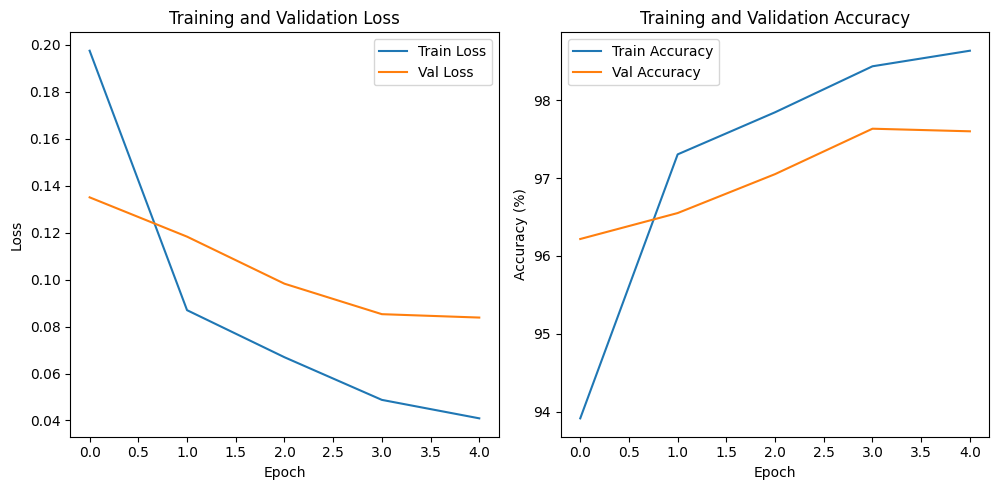

In [35]:
# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(training_history['train_losses'], label='Train Loss')
plt.plot(training_history['val_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(training_history['train_accuracies'], label='Train Accuracy')
plt.plot(training_history['val_accuracies'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
# Let's test with extremely conservative settings
print("Testing Laplace approximation with conservative settings...")

# Make sure the model is on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Create the Laplace approximation
laplace = KroneckerLaplace(model, likelihood='classification')

# Compute the posterior
print("Computing posterior...")
laplace.compute_posterior(
    train_loader=train_loader,
    prior_precision=1.0,
    num_samples=len(train_dataset)  # Small sample for testing
)

Testing Laplace approximation with conservative settings...
Computing posterior...
Registering hooks...
Registered hooks for layer: network.0
Registered hooks for layer: network.2
Registered hooks for layer: network.4
Estimating Kronecker factors...
Processing up to 60000 samples...
Processed 16000 samples...
Processed 32000 samples...
Processed 48000 samples...
Processed 54000 samples...
Computing final Kronecker factors...
Layer network.0: Q shape torch.Size([784, 784]), H shape torch.Size([1200, 1200])
  Q norm: 266.830048, H norm: 0.034641
Layer network.2: Q shape torch.Size([1200, 1200]), H shape torch.Size([1200, 1200])
  Q norm: 122.462364, H norm: 0.034641
Layer network.4: Q shape torch.Size([1200, 1200]), H shape torch.Size([10, 10])
  Q norm: 400.192596, H norm: 0.003163
Removing hooks...
Posterior computation completed!


In [43]:
# Evaluation functions
def evaluate_laplace_model(laplace, test_loader, num_samples=20, temperature=0.001):
    """Evaluate the model with Laplace approximation"""
    laplace.model.eval()
    correct = 0
    total = 0
    uncertainties = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            mean_probs, uncertainty = laplace.predictive_distribution(
                data, num_samples=num_samples, temperature=temperature
            )
            
            _, predicted = mean_probs.max(1)
            
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            uncertainties.extend(uncertainty.cpu().numpy())
    
    accuracy = 100. * correct / total
    avg_uncertainty = np.mean(uncertainties)
    
    return accuracy, avg_uncertainty, uncertainties

def evaluate_standard_model(model, test_loader):
    """Evaluate the standard model"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy

In [44]:
# Test standard model first
print("\nEvaluating standard model...")
standard_accuracy = evaluate_standard_model(model, test_loader)
print(f"Standard Model Accuracy: {standard_accuracy:.2f}%")


Evaluating standard model...
Standard Model Accuracy: 97.87%


In [45]:
# Test Laplace with very conservative temperatures
print("\nTesting Laplace with different temperatures:")
temperatures = [0.0001, 0.001, 0.01, 0.1]

best_accuracy = 0
best_temperature = 0
best_uncertainty = 0

for temp in temperatures:
    accuracy, uncertainty, _ = evaluate_laplace_model(
        laplace, test_loader, num_samples=10, temperature=temp
    )
    print(f"Temperature {temp}: Accuracy = {accuracy:.2f}%, Uncertainty = {uncertainty:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_temperature = temp
        best_uncertainty = uncertainty

print(f"\nBest configuration:")
print(f"Temperature: {best_temperature}")
print(f"Laplace Accuracy: {best_accuracy:.2f}%")
print(f"Standard Accuracy: {standard_accuracy:.2f}%")
print(f"Uncertainty: {best_uncertainty:.4f}")


Testing Laplace with different temperatures:



KeyboardInterrupt



In [46]:
accuracy, uncertainty, _ = evaluate_laplace_model(
    laplace, test_loader, num_samples=50, temperature=1.0
)
print(f"Temperature 1.0: Accuracy = {accuracy:.2f}%, Uncertainty = {uncertainty:.4f}")

Temperature 1.0: Accuracy = 24.90%, Uncertainty = 2.1691


In [47]:
accuracy, uncertainty, _ = evaluate_laplace_model(
    laplace, test_loader, num_samples=100, temperature=1.0
)
print(f"Temperature 1.0: Accuracy = {accuracy:.2f}%, Uncertainty = {uncertainty:.4f}")

Temperature 1.0: Accuracy = 26.23%, Uncertainty = 2.2140


In [48]:
accuracy, uncertainty, _ = evaluate_laplace_model(
    laplace, test_loader, num_samples=200, temperature=1.0
)
print(f"Temperature 1.0: Accuracy = {accuracy:.2f}%, Uncertainty = {uncertainty:.4f}")

Temperature 1.0: Accuracy = 31.10%, Uncertainty = 2.2394


In [49]:
accuracy, uncertainty, _ = evaluate_laplace_model(
    laplace, test_loader, num_samples=400, temperature=1.0
)
print(f"Temperature 1.0: Accuracy = {accuracy:.2f}%, Uncertainty = {uncertainty:.4f}")

Temperature 1.0: Accuracy = 35.64%, Uncertainty = 2.2482


In [23]:
# Let's also look at uncertainty for correct vs incorrect predictions
def analyze_uncertainty_by_accuracy(laplace, test_loader, num_samples=50):
    """Analyze uncertainty for correct vs incorrect predictions"""
    laplace.model.eval()
    correct_uncertainties = []
    incorrect_uncertainties = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get predictive distribution using Laplace approximation
            mean_probs, uncertainty = laplace.predictive_distribution(data, num_samples=num_samples)
            
            # Get predictions
            _, predicted = mean_probs.max(1)
            
            # Separate uncertainties for correct and incorrect predictions
            correct_mask = predicted.eq(target)
            incorrect_mask = ~correct_mask
            
            if correct_mask.any():
                correct_uncertainties.extend(uncertainty[correct_mask].cpu().numpy())
            if incorrect_mask.any():
                incorrect_uncertainties.extend(uncertainty[incorrect_mask].cpu().numpy())
    
    return correct_uncertainties, incorrect_uncertainties

In [24]:
correct_unc, incorrect_unc = analyze_uncertainty_by_accuracy(laplace, test_loader)

print(f"\nUncertainty Analysis:")
print(f"Average uncertainty for correct predictions: {np.mean(correct_unc):.4f}")
print(f"Average uncertainty for incorrect predictions: {np.mean(incorrect_unc):.4f}")
print(f"Number of correct predictions: {len(correct_unc)}")
print(f"Number of incorrect predictions: {len(incorrect_unc)}")


Uncertainty Analysis:
Average uncertainty for correct predictions: 0.0146
Average uncertainty for incorrect predictions: 0.0444
Number of correct predictions: 1993
Number of incorrect predictions: 8007


In [12]:
# Example of sampling individual weight configurations
print("\nSampling weight configurations...")
weight_samples = laplace.sample_weights(num_samples=3)
print(f"Sampled {len(weight_samples)} weight configurations")


Sampling weight configurations...
Sampled 3 weight configurations


In [13]:
# Example of getting predictions with uncertainty for a single batch
print("\nTesting on a single batch...")
data_iter = iter(test_loader)
test_data, test_target = next(data_iter)
test_data, test_target = test_data.to(device), test_target.to(device)

mean_probs, uncertainty = laplace.predictive_distribution(test_data, num_samples=50)
_, predicted = mean_probs.max(1)

print(f"Predictions for first 10 test samples:")
for i in range(min(10, len(test_data))):
    print(f"  Sample {i+1}: True={test_target[i].item()}, Pred={predicted[i].item()}, "
          f"Uncertainty={uncertainty[i].item():.4f}, "
          f"Correct={predicted[i].eq(test_target[i]).item()}")


Testing on a single batch...
Predictions for first 10 test samples:
  Sample 1: True=7, Pred=1, Uncertainty=0.0125, Correct=False
  Sample 2: True=2, Pred=1, Uncertainty=0.0044, Correct=False
  Sample 3: True=1, Pred=1, Uncertainty=0.0000, Correct=True
  Sample 4: True=0, Pred=1, Uncertainty=0.0000, Correct=False
  Sample 5: True=4, Pred=6, Uncertainty=0.2204, Correct=False
  Sample 6: True=1, Pred=1, Uncertainty=0.0000, Correct=True
  Sample 7: True=4, Pred=1, Uncertainty=0.0574, Correct=False
  Sample 8: True=9, Pred=1, Uncertainty=0.0004, Correct=False
  Sample 9: True=5, Pred=1, Uncertainty=0.0001, Correct=False
  Sample 10: True=9, Pred=1, Uncertainty=0.0000, Correct=False
